In [1]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.utils.tensorboard
import numpy as np
from torch.utils.tensorboard import SummaryWriter


### Load and Preprocess Data

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))]) # these values are the mean and std of the MNIST dataset

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

### Define Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128) # Flatten the image
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) # Use log_softmax for the NLLLoss

# Instantiate the model
model = Net()


### Move to GPU

In [5]:
print(torch. cuda. is_available())
print(torch.cuda.device_count())
cuda_ = "cuda:0"
device = torch.device(cuda_ if torch.cuda.is_available() else "cpu")
model.to(device)


True
1


Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Define Loss Function and Optimiser

In [6]:
# Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

### Train the Model

Takes 3-5 mins, 2 mins faster on GPU!

In [7]:
# Prepare TensorBoard writer
writer = SummaryWriter('runs/mnist_experiment')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", unit=" batch"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        # print(f"Predicted shape: {predicted.shape}, Labels shape: {labels.shape}")

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
                
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)
    
    # Print average training loss
    average_train_loss = running_loss / len(trainloader)
    print(f"Training Loss: {average_train_loss:.4f}, Valid Accuracy: {100 * correct / total:.2f}%")
    
    # Add to TensorBoard
    writer.add_scalar('training_loss', average_train_loss, epoch)
    
    # Validation Loop
    model.eval()
    val_running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).eq(labels.data).sum().item()
    
    valid_losses.append(val_running_loss / len(testloader))
    valid_accuracies.append(100 * correct / total)    

# Close the TensorBoard writer
writer.close()


Epoch 1/10:   0%|          | 0/938 [00:00<?, ? batch/s]

Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 47.61 batch/s]


Training Loss: 0.2341, Valid Accuracy: 92.75%


Epoch 2/10: 100%|██████████| 938/938 [00:18<00:00, 50.11 batch/s]


Training Loss: 0.1160, Valid Accuracy: 96.44%


Epoch 3/10: 100%|██████████| 938/938 [00:18<00:00, 51.17 batch/s]


Training Loss: 0.0881, Valid Accuracy: 97.32%


Epoch 4/10: 100%|██████████| 938/938 [00:18<00:00, 51.93 batch/s]


Training Loss: 0.0787, Valid Accuracy: 97.53%


Epoch 5/10: 100%|██████████| 938/938 [00:18<00:00, 51.18 batch/s]


Training Loss: 0.0669, Valid Accuracy: 97.96%


Epoch 6/10: 100%|██████████| 938/938 [00:18<00:00, 50.24 batch/s]


Training Loss: 0.0581, Valid Accuracy: 98.14%


Epoch 7/10: 100%|██████████| 938/938 [00:18<00:00, 51.30 batch/s]


Training Loss: 0.0542, Valid Accuracy: 98.31%


Epoch 8/10: 100%|██████████| 938/938 [00:18<00:00, 51.00 batch/s]


Training Loss: 0.0550, Valid Accuracy: 98.34%


Epoch 9/10: 100%|██████████| 938/938 [00:18<00:00, 51.15 batch/s]


Training Loss: 0.0459, Valid Accuracy: 98.54%


Epoch 10/10: 100%|██████████| 938/938 [00:18<00:00, 50.99 batch/s]


Training Loss: 0.0477, Valid Accuracy: 98.59%


### Test the Model

In [8]:
import plotly.graph_objects as go

# Plot for training and validation loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=train_losses,
                         mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=valid_losses,
                         mode='lines+markers', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss',
                  xaxis_title='Epoch', yaxis_title='Loss',
                  template='plotly_dark')
fig.show()

# Plot for training and validation accuracy
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=train_accuracies,
                         mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=valid_accuracies,
                         mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy',
                  xaxis_title='Epoch', yaxis_title='Accuracy (%)',
                  template='plotly_dark')
fig.show()


In [9]:
correct = 0
total = 0

# Turn off gradients for validation
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device) # Run on GPU
        # Forward pass
        log_ps = model(images)
        
        # Get the predictions
        _, predicted = torch.max(log_ps, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test accuracy: {(correct*100) / total}%")


Test accuracy: 97.24%


### Make Predictions!

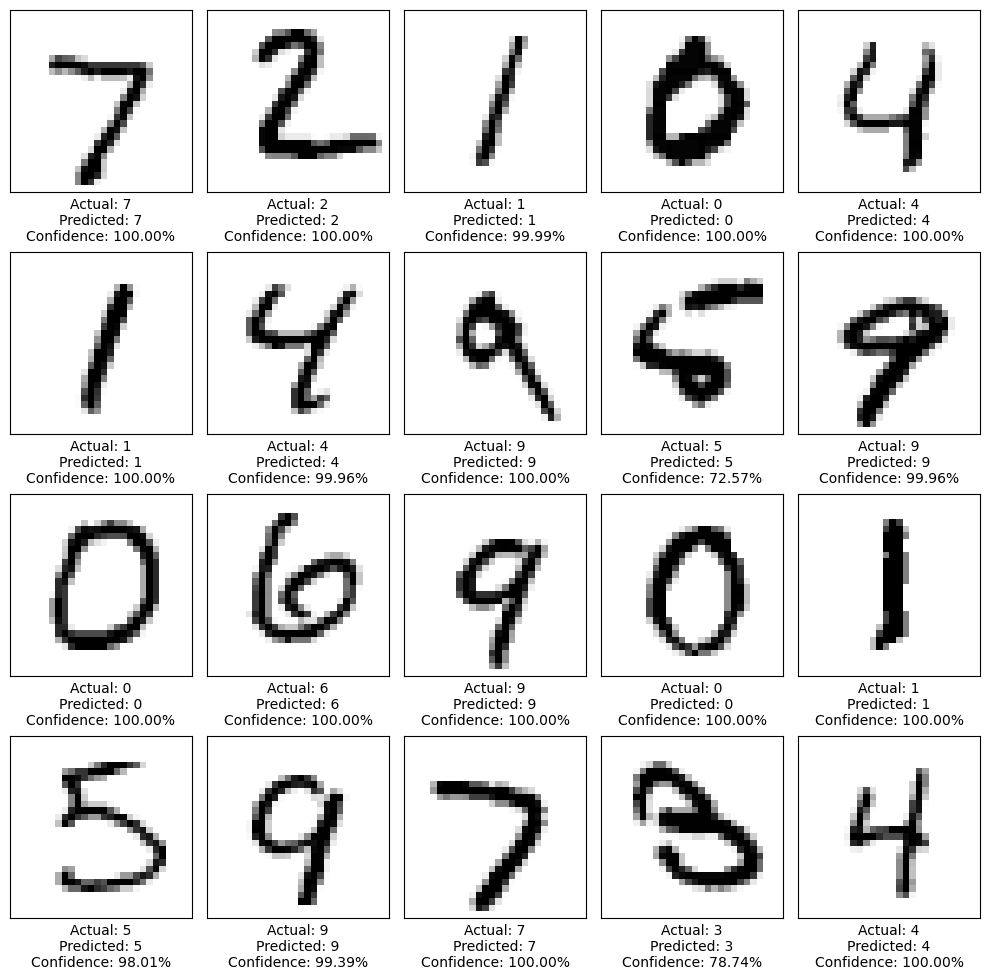

In [10]:
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.pyplot as plt

# Define the mean and standard deviation for the MNIST dataset
mnist_mean = 0.1307
mnist_std = 0.3081

def invert_normalization(tensor):
    """
    Inverts the normalization applied to the dataset.
    """
    tensor = tensor * mnist_std + mnist_mean  # Inverting normalization
    tensor = tensor.clamp(0, 1)  # Clamp values to be between 0 and 1
    return tensor

# Assuming 'model', 'testloader', and 'device' are properly defined
model.eval()
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)
probabilities = F.softmax(outputs, dim=1)


# Select a subset for plotting
images, preds, labels = images[:20], preds[:20], labels[:20]

plt.figure(figsize=(10,10))
confidences = []
index = 0
for i in range((20)):
    img = invert_normalization(images[i]).cpu().numpy().squeeze()  # Invert normalization, move to CPU, convert to numpy, and remove channel dimension
    label = labels[i].cpu().item()  # Move to CPU and get as Python number
    pred = preds[i].cpu().item()  
    confidence = probabilities[i][pred].cpu().item()  # Get the probability for the predicted class
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(f"Actual: {label}\nPredicted: {pred}\nConfidence: {confidence*100 :.2f}%")
plt.tight_layout()
plt.show()
